In [10]:
import tensorflow as tf
from keras.preprocessing import image
from keras.layers import Input
import os
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import keras.optimizers as optimizers
from keras.optimizers import Adam,SGD,RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
# Set the paths to your training and test data directories
train_dir = 'train/'
test_dir = 'test/' 

### <font color='green'> Counting the emotion labels in train and test dataset </font>

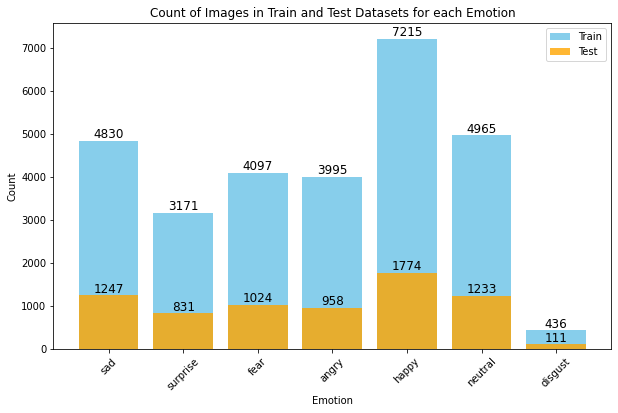

In [12]:
# Define emotion labels
emotion_labels = ['sad', 'surprise', 'fear', 'angry', 'happy', 'neutral','disgust']

# Function to count the number of images in each class folder
def count_images_in_folder(folder_path):
    image_counts = []
    for label in emotion_labels:
        class_folder_path = os.path.join(folder_path, label)
        num_images = len(os.listdir(class_folder_path))
        image_counts.append(num_images)
    return image_counts

# Get the counts of images in the 'train/' and 'test/' directories
train_image_counts = count_images_in_folder('train/')
test_image_counts = count_images_in_folder('test/')

# Create a count plot using matplotlib
plt.figure(figsize=(10, 6))
bars_train = plt.bar(emotion_labels, train_image_counts, color='skyblue', label='Train')
bars_test = plt.bar(emotion_labels, test_image_counts, color='orange', label='Test', alpha=0.8)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Count of Images in Train and Test Datasets for each Emotion')
plt.legend()

# Add text on each bar for the 'train/' set
for bar_train, bar_test in zip(bars_train, bars_test):
    height_train = bar_train.get_height()
    height_test = bar_test.get_height()
    plt.text(bar_train.get_x() + bar_train.get_width() / 2, height_train, str(int(height_train)), 
             ha='center', va='bottom', fontsize=12)
    plt.text(bar_test.get_x() + bar_test.get_width() / 2, height_test, str(int(height_test)), 
             ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45)
plt.show()


In [3]:
# Set the image dimensions and number of classes
input_shape = (48, 48, 1)
img_width, img_height = 48, 48
output_class  = 7  # Replace with the actual number of emotion classes

In [4]:
# Set up the data generators
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=128,
                                                    color_mode="grayscale",                                            
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=128,
                                                  color_mode="grayscale",
                                                  class_mode='categorical')


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
model = Sequential()
# convolutional layers
model.add(Conv2D(256, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))


model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(output_class, activation='softmax'))

optimizer = optimizers.Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 256)       2560      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 256)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 512)       1180160   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 512)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 10, 512)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 512)         2359808   
__________

In [6]:
early_stopping = EarlyStopping(monitor = 'val_acc',patience=10)

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_generator.samples // train_generator.batch_size,
                              epochs=100,
                              validation_data=test_generator,
                              validation_steps=test_generator.samples // test_generator.batch_size,
                              callbacks=[early_stopping]
                             )

Epoch 1/100
224/224 [==============================] - 510s 2s/step - loss: 1.8252 - acc: 0.2478 - val_loss: 1.8124 - val_acc: 0.2490
Epoch 2/100
224/224 [==============================] - 121s 542ms/step - loss: 1.7928 - acc: 0.2580 - val_loss: 1.7330 - val_acc: 0.2882
Epoch 3/100
224/224 [==============================] - 121s 539ms/step - loss: 1.6730 - acc: 0.3236 - val_loss: 1.5145 - val_acc: 0.4141
Epoch 4/100
224/224 [==============================] - 121s 540ms/step - loss: 1.5300 - acc: 0.3974 - val_loss: 1.3641 - val_acc: 0.4710
Epoch 5/100
224/224 [==============================] - 121s 540ms/step - loss: 1.4363 - acc: 0.4459 - val_loss: 1.2847 - val_acc: 0.5052
Epoch 6/100
224/224 [==============================] - 123s 549ms/step - loss: 1.3802 - acc: 0.4683 - val_loss: 1.2529 - val_acc: 0.5202
Epoch 7/100
224/224 [==============================] - 368s 2s/step - loss: 1.3440 - acc: 0.4860 - val_loss: 1.2092 - val_acc: 0.5364
Epoch 8/100
224/224 [==========================

Epoch 61/100
224/224 [==============================] - 1464s 7s/step - loss: 0.9360 - acc: 0.6509 - val_loss: 0.9614 - val_acc: 0.6441
Epoch 62/100
224/224 [==============================] - 1543s 7s/step - loss: 0.9385 - acc: 0.6511 - val_loss: 0.9654 - val_acc: 0.6420
Epoch 63/100
224/224 [==============================] - 1456s 7s/step - loss: 0.9377 - acc: 0.6496 - val_loss: 0.9600 - val_acc: 0.6461
Epoch 64/100
224/224 [==============================] - 1468s 7s/step - loss: 0.9328 - acc: 0.6517 - val_loss: 0.9570 - val_acc: 0.6483
Epoch 65/100
224/224 [==============================] - 1462s 7s/step - loss: 0.9253 - acc: 0.6537 - val_loss: 0.9471 - val_acc: 0.6546
Epoch 66/100
224/224 [==============================] - 1461s 7s/step - loss: 0.9250 - acc: 0.6558 - val_loss: 0.9400 - val_acc: 0.6507
Epoch 67/100
224/224 [==============================] - 1510s 7s/step - loss: 0.9229 - acc: 0.6568 - val_loss: 0.9591 - val_acc: 0.6487
Epoch 68/100
224/224 [==========================

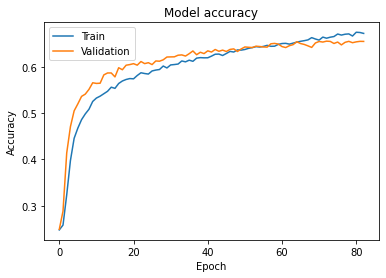

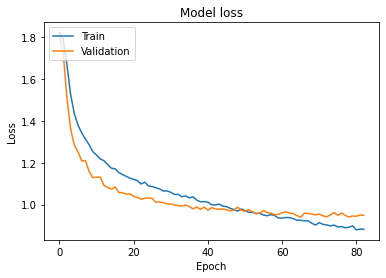

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=test_generator.samples // test_generator.batch_size)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Test Loss: 0.9599085652402469
Test Accuracy: 0.6512276785714286


In [15]:
y_pred = model.predict_generator(test_generator, steps=test_generator.samples // test_generator.batch_size)

In [16]:
y_pred

array([[7.83878961e-04, 3.84986691e-07, 1.99418310e-02, ...,
        8.95471871e-03, 9.70221519e-01, 1.13475326e-05],
       [3.35990526e-02, 2.92357348e-04, 6.62113503e-02, ...,
        8.59273821e-02, 8.12080979e-01, 3.60478676e-04],
       [1.45883523e-05, 6.71613432e-09, 5.85472808e-05, ...,
        1.17142722e-01, 4.44349098e-05, 1.77393504e-03],
       ...,
       [3.58306170e-02, 7.75548106e-04, 1.08789196e-02, ...,
        5.47814250e-01, 1.35511503e-01, 7.50520499e-04],
       [5.70035815e-01, 2.75579020e-02, 1.13242134e-01, ...,
        2.86255907e-02, 2.84768753e-02, 2.29384914e-01],
       [2.06558430e-03, 4.37972813e-05, 2.36707274e-03, ...,
        6.89084455e-02, 1.30970369e-03, 3.84657807e-03]], dtype=float32)

In [17]:
y_pred_labels = np.argmax(y_pred, axis=1)

In [18]:
y_pred_labels

array([5, 5, 3, ..., 4, 0, 3], dtype=int64)

In [19]:
y_true_labels = test_generator.classes[:y_pred_labels.shape[0]]

In [20]:
y_true_labels

array([0, 0, 0, ..., 6, 6, 6])

In [21]:
y_true_labels.shape,y_pred_labels.shape

((7168,), (7168,))

In [22]:
confusion_matrix(y_true_labels, y_pred_labels)

array([[118,   8,  94, 270, 216, 131, 121],
       [ 14,   1,   9,  31,  21,  22,  13],
       [152,  10, 101, 255, 228, 138, 140],
       [243,  15, 180, 447, 422, 230, 237],
       [142,   9, 121, 328, 290, 182, 161],
       [179,  11, 102, 340, 266, 173, 176],
       [ 95,   7,  82, 214, 183, 138, 102]], dtype=int64)

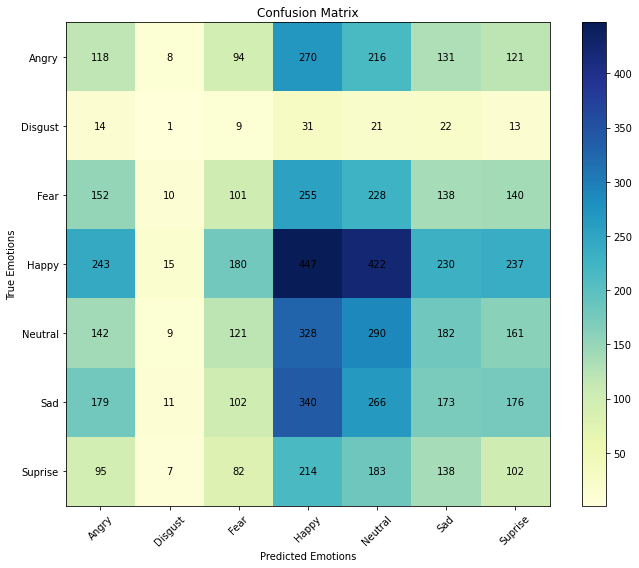

In [1]:
import numpy as np
import matplotlib.pyplot as plt

confusion_matrix = np.array([[118, 8, 94, 270, 216, 131, 121],
                             [14, 1, 9, 31, 21, 22, 13],
                             [152, 10, 101, 255, 228, 138, 140],
                             [243, 15, 180, 447, 422, 230, 237],
                             [142, 9, 121, 328, 290, 182, 161],
                             [179, 11, 102, 340, 266, 173, 176],
                             [95, 7, 82, 214, 183, 138, 102]])

emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise']

plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix, cmap='YlGnBu')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Emotions')
plt.ylabel('True Emotions')
plt.xticks(np.arange(len(emotions)), emotions, rotation=45)
plt.yticks(np.arange(len(emotions)), emotions)
plt.colorbar()

for i in range(len(emotions)):
    for j in range(len(emotions)):
        plt.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='black')

plt.tight_layout()
plt.show()


In [23]:
class_names = list(test_generator.class_indices.keys())
classification_rep = classification_report(y_true_labels, y_pred_labels, target_names=class_names)
print(classification_rep)

              precision    recall  f1-score   support

       angry       0.13      0.12      0.12       958
     disgust       0.02      0.01      0.01       111
        fear       0.15      0.10      0.12      1024
       happy       0.24      0.25      0.24      1774
     neutral       0.18      0.24      0.20      1233
         sad       0.17      0.14      0.15      1247
    surprise       0.11      0.12      0.12       821

    accuracy                           0.17      7168
   macro avg       0.14      0.14      0.14      7168
weighted avg       0.17      0.17      0.17      7168



In [24]:
test_generator.class_indices.keys()

dict_keys(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

In [25]:
list(test_generator.class_indices.keys())

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [16]:
# Save the model
model.save('emotion_model_cnn_final.h5')

In [17]:
# Load the saved model
from keras.models import load_model
loaded_model = load_model('emotion_model_cnn_final.h5')

In [24]:
# Make predictions on the test data
predictions = model.predict_generator(test_generator, steps=test_generator.samples // test_generator.batch_size)
predicted_labels = np.argmax(predictions, axis=1)

In [25]:
predicted_labels

array([3, 4, 3, ..., 3, 0, 3], dtype=int64)

In [22]:
# Map the predicted labels to class names
class_names = train_generator.class_indices
class_names = dict((v, k) for k, v in class_names.items())
predicted_class_names = [class_names[label] for label in predicted_labels]

# Print the predicted class names for the first few samples
print('Predicted Class Names:', predicted_class_names[:10])

Predicted Class Names: ['happy', 'happy', 'sad', 'happy', 'happy', 'neutral', 'angry', 'angry', 'neutral', 'surprise']


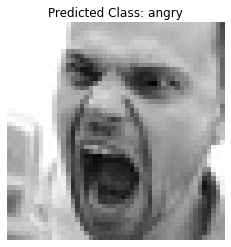

In [26]:
from keras.preprocessing import image
import numpy as np
import cv2

# Load and preprocess the input image
image_path = 'test/angry/PrivateTest_1221822.jpg'
img = image.load_img(image_path, target_size=(img_width, img_height))
img = image.img_to_array(img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
img = np.expand_dims(img, axis=0)
img = np.expand_dims(img, axis=-1)
img = img / 255.0  # Normalize pixel values to [0, 1]

# Make a prediction on the input image
prediction = loaded_model.predict(img)
predicted_label = np.argmax(prediction)

# Map the predicted label to class name
class_names = train_generator.class_indices
class_names = dict((v, k) for k, v in class_names.items())
predicted_class_name = class_names[predicted_label]

# Display the input image and predicted class name
plt.imshow(np.squeeze(img), cmap='gray')
plt.axis('off')
plt.title('Predicted Class: ' + predicted_class_name)
plt.show()


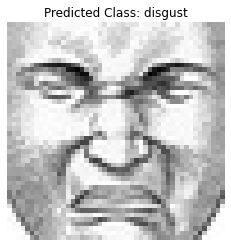

In [27]:
# Load and preprocess the input image
image_path = 'test/disgust/PublicTest_57583458.jpg'
img = image.load_img(image_path, target_size=(img_width, img_height))
img = image.img_to_array(img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
img = np.expand_dims(img, axis=0)
img = np.expand_dims(img, axis=-1)
img = img / 255.0  # Normalize pixel values to [0, 1]

# Make a prediction on the input image
prediction = loaded_model.predict(img)
predicted_label = np.argmax(prediction)

# Map the predicted label to class name
class_names = train_generator.class_indices
class_names = dict((v, k) for k, v in class_names.items())
predicted_class_name = class_names[predicted_label]

# Display the input image and predicted class name
plt.imshow(np.squeeze(img), cmap='gray')
plt.axis('off')
plt.title('Predicted Class: ' + predicted_class_name)
plt.show()


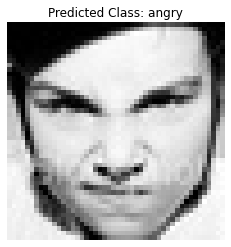

In [28]:
# Load and preprocess the input image
image_path = 'test/angry/PrivateTest_31103368.jpg'
img = image.load_img(image_path, target_size=(img_width, img_height))
img = image.img_to_array(img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
img = np.expand_dims(img, axis=0)
img = np.expand_dims(img, axis=-1)
img = img / 255.0  # Normalize pixel values to [0, 1]

# Make a prediction on the input image
prediction = loaded_model.predict(img)
predicted_label = np.argmax(prediction)

# Map the predicted label to class name
class_names = train_generator.class_indices
class_names = dict((v, k) for k, v in class_names.items())
predicted_class_name = class_names[predicted_label]

# Display the input image and predicted class name
plt.imshow(np.squeeze(img), cmap='gray')
plt.axis('off')
plt.title('Predicted Class: ' + predicted_class_name)
plt.show()
